#### Sara Rosselli 5204959

# Jupyter (Modern) Museum

### Obiettivi:

Il tema centrale della prima parte di questo notebook è l'analisi di tre tra le opere d'arte più celebri della storia, tutte appartenenti a correnti artistiche differenti, e di conseguenza realizzate con tecniche diverse e obiettivi diversi da parte degli autori; lo scopo è proprio quello di mostrare come questi obiettivi possano essere enfatizzati attraverso un'operazione di quantizzazione dei colori, effettuata attraverso l'implementazione dell'algoritmo "k-means", così da ottenere un'immagine più "semplice" dal punto di vista cromatico, portando ogni pixel nel colore più vicino tra i k (numero scelto arbitrariamente) colori più frequenti nel dipinto. Quest'immagine verrà sovrapposta ai bordi neri enfatizzati così da ottenere una versione cartoonata di quella originale.

La seconda parte, dall'aspetto un po' più tecnico, prende proprio quest'immagine cartoonata e permette di crearne una versione "pop art" dando carta bianca a chi utlizza il notebook sui colori da cambiare e con quali colori rimpiazzarli.

In [1]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
from scipy import signal
from skimage import img_as_ubyte, img_as_float
import ipywidgets as widgets
from IPython.display import display
from ipywidgets import interact, IntSlider

### Caso di test 1 ("Gioconda" di Leonardo Da Vinci)

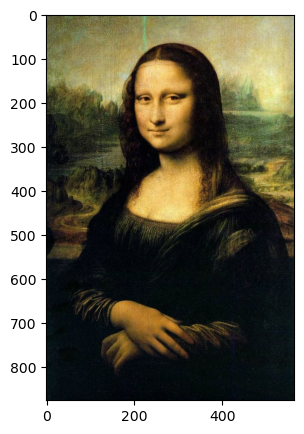

In [2]:
img = cv2.imread('images/gioconda.jpg')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) # converto l'immagine dal formato BGR di OpenCV al formato RGB
plt.figure(figsize=(10, 5))
plt.imshow(img) 
plt.show()

### Metodo 1 (realizzazione della edge detection):

Creo la versione in bianco e nero dell'immagine originale da usare per rilevare i bordi;

applico il filtro bilaterale (filtro passa basso per preservare i contorni ma ridurre il rumore) della libreria cv2 all'immagine originale così da ottenere l'input per la quantizzazione

In [3]:
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
gray = cv2.medianBlur(gray, 9)
gray = img_as_float(gray)
img_f = cv2.bilateralFilter(img, 9, 250, 250)

In [4]:
# Funzione che rileva i gradienti di intensità in un'immagine utilizzando il kernel
# di Sobel per eseguire l'operazione di convoluzione sull'immagine.
def get_borders(img):
    k=np.array([[1,2,1],[0,0,0],[-1,-2,-1]])
    return np.sqrt((signal.convolve2d(img, k.T))**2+(signal.convolve2d(img,k))**2)

In [5]:
def get_edges(threshold):
    edges = get_borders(gray) # conterrà l'immagine dei bordi, dove i valori più alti corrispondono a una forte variazione dell'intensità, indicativa dei bordi.
    edges_normalized = edges / np.max(edges) # ridimensiona i valori dell'immagine in modo che siano compresi tra 0 e 1.
    edges_normalized = img_as_float(edges_normalized)
    
    # Applica una soglia normalizzata all'immagine dei bordi. Normalizzare la soglia permette di avere una soglia che funziona
    # indipendentemente dall'intervallo di valori dei pixel nell'immagine. In questo modo, possiamo utilizzare la stessa
    # soglia su immagini con diversi intervalli di valori di pixel. I pixel con intensità al di sotto della soglia
    # diventeranno 0, mentre quelli al di sopra diventeranno 1.
    edges = edges_normalized < threshold/100.0
    return edges

In [6]:
def plot_image(threshold):
    global edges
    edges = get_edges(threshold)
    plt.figure(figsize=(10, 5))
    plt.subplots_adjust(wspace=0.9)
    plt.subplot(1, 3, 1)
    plt.imshow(gray, cmap='gray')
    plt.subplot(1, 3, 2)
    plt.imshow(edges, cmap='gray')
    plt.subplot(1, 3, 3)
    plt.imshow(img_f, cmap='gray')
    plt.show()

In [7]:
# Crea uno slider interattivo per permettere la scelta della soglia per gli edges
threshold_slider = IntSlider(min=1, max=100, step=1, value=10)

# Visualizza l'immagine con gli edges interattivamente
interact(plot_image, threshold=threshold_slider)

interactive(children=(IntSlider(value=10, description='threshold', min=1), Output()), _dom_classes=('widget-in…

<function __main__.plot_image(threshold)>

### Metodo 2 (quantizzazione):

Inizia ora l'implementazione dell'algoritmo k-means:


l'immagine viene trasformata in una matrice, dove ogni riga rappresenta un pixel e le colonne rappresentano i canali di colori;

vengono inizializzati casualmente i k centroidi scegliendoli casualmente dal vettore/matrice di dati;

ciascun punto viene assegnato al cluster più vicino in base ai centroidi correnti;

calcolo la distorsione iniziale: la distorsione rappresenta quanto i punti di un cluster sono distanti dal centroide del cluster stesso;

la successione di iterazioni continua fintanto che la differenza tra la distorsione corrente e quella precedente è maggiore di 1: quando l'algoritmo raggiunge una distorsione bassa, significa che i centroidi sono scelti in modo tale da rappresentare in modo accurato i dati e che i punti sono assegnati ai cluster in modo coerente con la struttura dell'immagine. Durante ogni iterazione, l'algoritmo aggiorna l'assegnazione dei cluster e sposta i centroidi in modo che la distorsione complessiva sia ridotta;

restituisce i centroidi finali, l'assegnazione del cluster per ciascun punto, e la distorsione finale ottenuta.

In [8]:
# Funzione che seleziona casualmente K centroidi iniziali da un vettore di dati v e li restituisce.
def choose_random(K, v):
    n = len(v)
    idx = np.random.randint(0, n, K) # per generare indici casuali nel range da 0 a n (numero di punti nel vettore)
    return v[idx]

# Funzione che calcola la distanza tra due punti
def distance(x1, x2):
    return np.matmul((x1-x2), (x1-x2).transpose())

# Funzione che assegna a ciascun punto nel vettore v l'indice del cluster a cui appartiene,
# basandosi sulla distanza euclidea tra il punto e i centroidi cent. La funzione restituisce un array
# con gli indici dei cluster assegnati a ciascun punto.
def cluster_assignment(cent, v):
    return ((v - cent[:, np.newaxis]) ** 2).sum(axis=2).argmin(axis=0)

# Funzione che aggiorna le posizioni dei centroidi cent calcolando la media dei punti nel cluster corrispondente.
def move_centroid(cent, c, v):
    for i in range(len(cent)):
        vec = v[c==i]
        cent[i] = np.mean(vec, axis=0)
    return cent

# Funzione che calcola la distorsione del clustering data la posizione dei centroidi cent, l'assegnazione del cluster c,
# e il vettore di dati v. E' calcolata come la somma delle distanze quadratiche tra ciascun punto e il suo centroide associato,
# divisa per il numero totale di punti.
def distortion(cent, c, v):
    return ((cent[c] - v) ** 2).sum() / v.shape[0]

# Funzione che implementa l'algoritmo kmeans: prende un'immagine img (da convertire in un vettore di 
# punti vec_img) e un numero desiderato di cluster K; restituisce i centroidi finali ottimali, l'assegnazione 
# del cluster per ciascun punto. La funzione permette anche di visualizzare l'immagine
# originale e quantizzata. Durante ogni iterazione vengono aggiornati i centroidi e riassegnati i punti ai cluster corrispondenti
def k_means(img, K, plot=True, verbose=False):
    l, w, ch = img.shape
    vec_img = img.reshape(-1, ch).astype(int)
    cent = choose_random(K, vec_img)
    c = cluster_assignment(cent, vec_img)
    last_dist = distortion(cent, c, vec_img) + 100
    curr_dist = last_dist - 100
    history = [curr_dist]
    # stoppo le iterazioni quando la distorsione è minore di 1
    while last_dist - curr_dist > 1:
        last_dist = curr_dist
        c = cluster_assignment(cent, vec_img)
        cent = move_centroid(cent, c, vec_img)    
        curr_dist = distortion(cent, c, vec_img)
        history.append(curr_dist)
    if plot:
        img_compressed = cent[c].reshape(img.shape)
        plt.figure(figsize=(15, 5))
        plt.subplot(1, 2, 1)
        plt.imshow(img)
        plt.title('Immagine filtrata')
        plt.axis('off')
        plt.subplot(1, 2, 2)
        plt.imshow(img_compressed.astype(np.uint8))
        plt.title('Immagine quantizzata')
        plt.axis('off')
        
    return cent, c, history[-1]

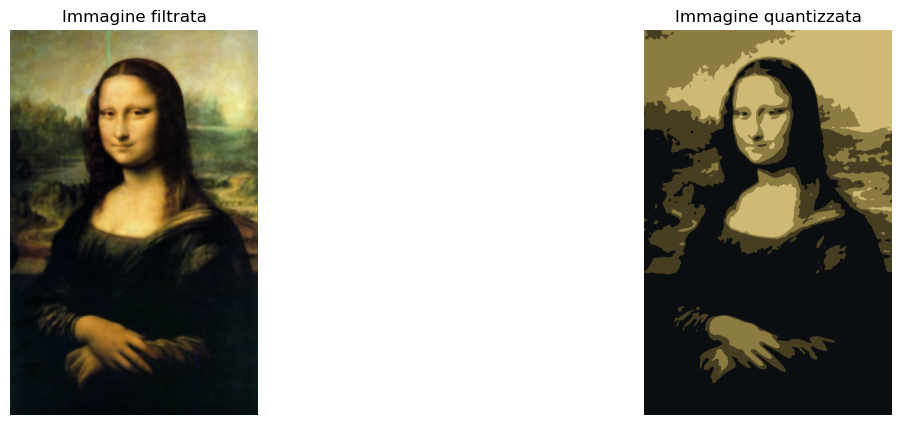

In [10]:
cent, c, dist = k_means(img_f, 4)

Combino l'immagine quantizzata con gli edges per ottenere l'immagine cartoonata

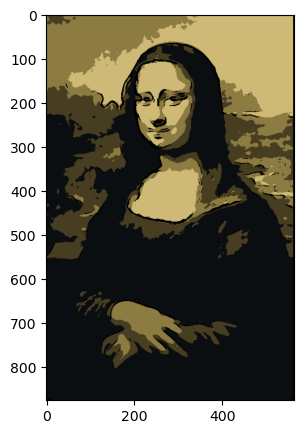

In [11]:
img_q = cent[c].reshape(img_f.shape)
edges = cv2.UMat(np.array(edges, dtype=np.uint8))

global cartoon

cartoon = img_q.copy()
edges = cv2.resize(edges, (cartoon.shape[1], cartoon.shape[0]))

cartoon[edges.get() == 0] = 0

plt.figure(figsize=(10, 5))
plt.imshow(cartoon)
plt.show()

#### Osservazioni:

Una delle caratteristiche peculiari di questo dipinto è la focalizzazione sulla donna rispetto allo sfondo, il quale è stato sfocato già nel quadro originale proprio per mettere in risalto i dettagli della figura.
La quantizzazione e la edge detection rimangono su questa linea, poichè dall'immagine risultante è evidente come lo sfondo sia ormai privo di dettagli (principalmente a causa della scomparsa dei toni del verde degli alberi per lasciare spazio invece ai colori marroni/grigi che appartengono alla figura femminile), mentre i tratti del volto sono ancora ben distinguibili e permettono alla donna di mantenere il suo caratteristico sguardo.

### Metodo 3 (evidenziatore delle parti cromaticamente simili di un'immagine in HSV):

La funzione seguente prende in input le coordinate di un pixel di un'immagine e il suo rispettivo colore in RGB e ne ricava i valori HSV; in seguito seleziona tutti i pixel dell'immagine con gli stessi valori HSV, crea una maschera sull'immagine originale e tinge del colore in input tutti i pixel selezionati, rendendo neri e restanti. L'idea originaria era quella di riutilizzare questa funzione nella creazione dell'effetto "pop art", ma dopo vari insuccessi ho deciso di cambiare approccio, ma ho voluto conservarla all'interno del notebook

In [12]:
def highlight_color(img, target_color, pixel_row, pixel_col):
    hsv_image = cv2.cvtColor(img.astype(np.uint8), cv2.COLOR_RGB2HSV) # converto l'immagine da RGB a HSV
    target_color_hsv = np.array([target_color[0] / 2, target_color[1] / 255, target_color[2] / 255])

    h_channel = hsv_image[:, :, 0]
    s_channel = hsv_image[:, :, 1]
    v_channel = hsv_image[:, :, 2]

    plt.figure(figsize=(15, 5))
    plt.subplots_adjust(wspace=0.9)
    plt.subplot(1, 3, 1)
    plt.imshow(h_channel, cmap='hsv')
    plt.title('Hue Channel (H)')
    plt.colorbar()

    plt.subplot(1, 3, 2)
    plt.imshow(s_channel, cmap='gray') 
    plt.title('Saturation Channel (S)')
    plt.colorbar()

    plt.subplot(1, 3, 3)
    plt.imshow(v_channel, cmap='gray')
    plt.title('Value Channel (V)')
    plt.colorbar()

    plt.show()
    
    # Viene definito un intervallo di colori preso in considerazione che viene usato per i confronti, basandosi sui valori nei
    # canali di tonalità, saturazione e valore del pixel dato in input, con una tolleranza di +/- 8.
    lower_bound = np.array([h_channel[pixel_row, pixel_col] - 8, s_channel[pixel_row, pixel_col] - 8, v_channel[pixel_row, pixel_col] - 8]) 
    upper_bound = np.array([h_channel[pixel_row, pixel_col] + 8, s_channel[pixel_row, pixel_col] + 8, v_channel[pixel_row, pixel_col] + 8])

    # creo una maschera che identifica i pixel il cui valore rientra nell'intervallo definito:
    # la maschera sarà bianca per i pixel che rientrano nell'intervallo e nera per quelli che non vi rientrano.
    color_mask = cv2.inRange(hsv_image, lower_bound, upper_bound) 

    result_image = img.copy()

    target_color_bgr = target_color[::-1]
    
    # applico la maschera all'immagine originale colorando del colore in input i pixel che rientravano nella soglia
    result_image[color_mask != 0] = target_color_bgr
    result_image[color_mask == 0] = [0, 0, 0]  # rendo il resto nero
    
    result_image = result_image.astype(np.uint8)
    
    print(f"Hue value in the hue channel at position ({pixel_row}, {pixel_col}): {h_channel[pixel_row, pixel_col]}")

    plt.imshow(color_mask, cmap='gray')
    plt.title('Color Mask')
    plt.colorbar()
    plt.show()

    return result_image

Colore del pixel alla posizione (80, 80): [141 124  66]


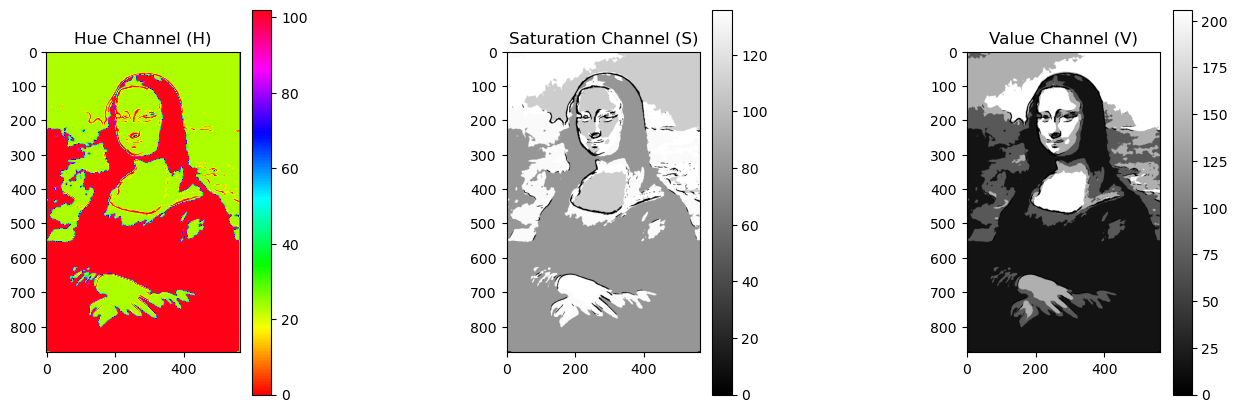

Hue value in the hue channel at position (80, 80): 23


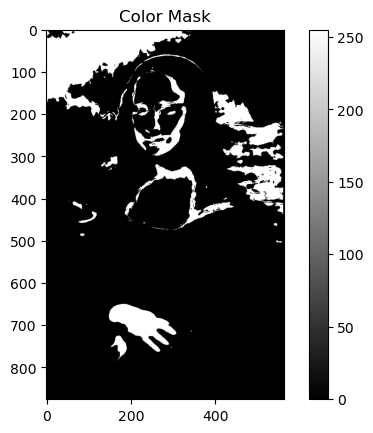

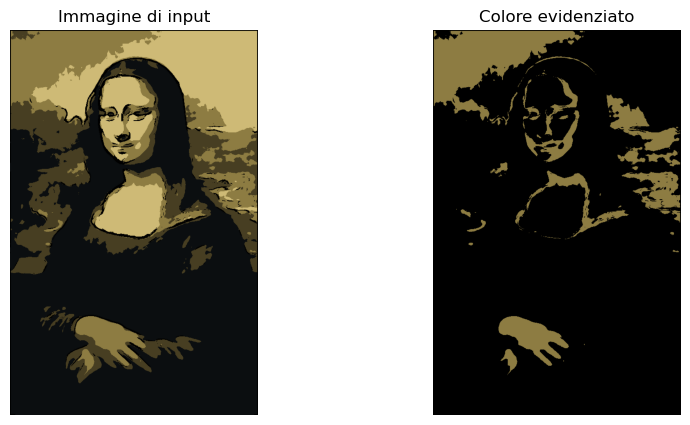

In [13]:
# Scegli il pixel da esaminare (ad esempio, il pixel nella riga 80 e colonna 80)
pixel_row = 80
pixel_col = 80

pixel_color = cartoon[pixel_row, pixel_col]
print(f"Colore del pixel alla posizione ({pixel_row}, {pixel_col}): {pixel_color}")

highlighted_image = highlight_color(cartoon, pixel_color, pixel_row, pixel_col)

plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.imshow(cartoon)
plt.title('Immagine di input')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(cv2.cvtColor(highlighted_image, cv2.COLOR_BGR2RGB))
plt.title('Colore evidenziato')
plt.axis('off')

plt.show()

### Metodo 4 (realizzazione del pop art effect):

Di seguito il codice per la seconda parte del notebook che permette di creare un effetto "pop art" lavorando sui canali RGB:

la funzione principale è la pop_art_effect_rgb, che applica l'effetto pop art all'immagine RGB: prende in input l'immagine, le coordinate di un pixel nella matrice di pixel, e i valori di spostamento per i canali di colore rosso, verde e blu scelti dall'utente. La funzione identifica il colore del pixel selezionato e crea una maschera per individuare tutti i pixel con quel colore a cui applica lo spostamento;

le altre funzioni si occupano principalmente dell'interfaccia utente interattiva e del collegamento alla pop_art_effect_rgb

In [15]:
def pop_art_effect_rgb(img, pixel_row, pixel_col, red_shift=0, green_shift=0, blue_shift=0):
    target_color = img[pixel_row, pixel_col]
    mask = np.all(img == target_color, axis=-1)
    img[mask] = np.clip(img[mask] + [red_shift, green_shift, blue_shift], 0, 255)
    return img

def update_pop_art_rgb(red_shift, green_shift, blue_shift, row, col):
    global current_image
    current_image = pop_art_effect_rgb(current_image, row, col, red_shift, green_shift, blue_shift)
    current_image = current_image.astype(np.uint8)
    plt.figure(figsize=(10, 5))
    return plt.imshow(current_image)

def save_image(b):
    global current_image
    current_image = current_image.astype(np.uint8)
    plt.imsave('saved_image.png', current_image)

    red_slider.value = 0
    green_slider.value = 0
    blue_slider.value = 0
    row_slider.value = cartoon.shape[0]//2
    col_slider.value = cartoon.shape[1]//2

current_image = cartoon.copy()

red_slider = widgets.IntSlider(min=-255, max=255, step=1, value=0, description='Red Shift:')
green_slider = widgets.IntSlider(min=-255, max=255, step=1, value=0, description='Green Shift:')
blue_slider = widgets.IntSlider(min=-255, max=255, step=1, value=0, description='Blue Shift:')
row_slider = widgets.IntSlider(min=0, max=cartoon.shape[0]-1, step=1, value=cartoon.shape[0]//2, description='y:')
col_slider = widgets.IntSlider(min=0, max=cartoon.shape[1]-1, step=1, value=cartoon.shape[1]//2, description='x:')
save_button = widgets.Button(description='Save Image')
save_button.on_click(save_image)

interactive_pop_art_rgb = interact(update_pop_art_rgb, red_shift=red_slider, green_shift=green_slider, blue_shift=blue_slider, row=row_slider, col=col_slider, continuous_update=False)

display(save_button)

interactive(children=(IntSlider(value=0, description='Red Shift:', max=255, min=-255), IntSlider(value=0, desc…

Button(description='Save Image', style=ButtonStyle())

### Caso di test 2 ("Madonna" di Munch)

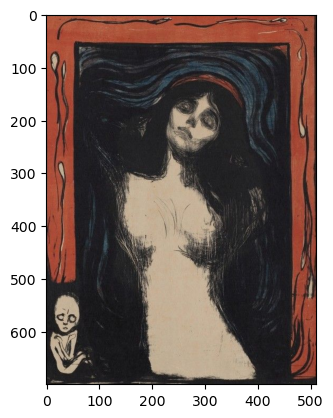

<Figure size 1000x500 with 0 Axes>

In [14]:
img = cv2.imread('images/madonnaMunch.jpg')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) #converto l'immagine dal formato BGR di OpenCV al formato RGB
plt.imshow(img)
plt.figure(figsize=(10, 5))
plt.show()

In [15]:
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
gray = cv2.medianBlur(gray, 9)
gray = img_as_float(gray)
img_f = cv2.bilateralFilter(img, 9, 250, 250)

threshold_slider = IntSlider(min=1, max=100, step=1, value=10)

interact(plot_image, threshold=threshold_slider)

interactive(children=(IntSlider(value=10, description='threshold', min=1), Output()), _dom_classes=('widget-in…

<function __main__.plot_image(threshold)>

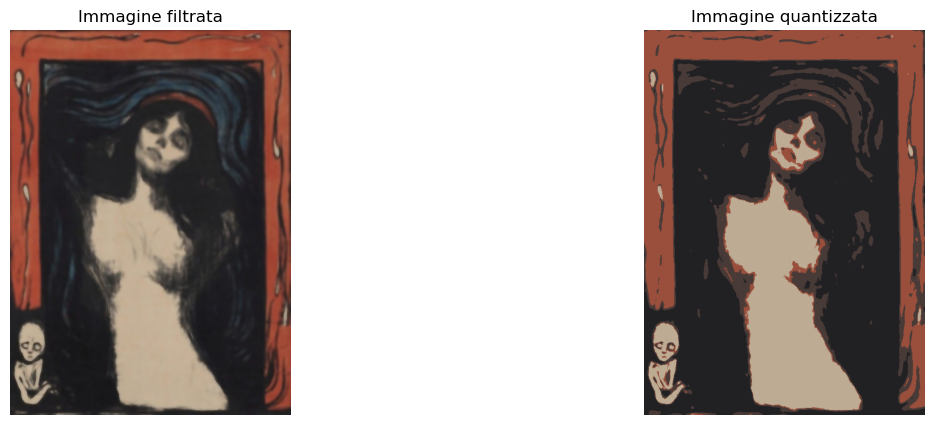

In [16]:
cent, c, dist = k_means(img_f, 4)

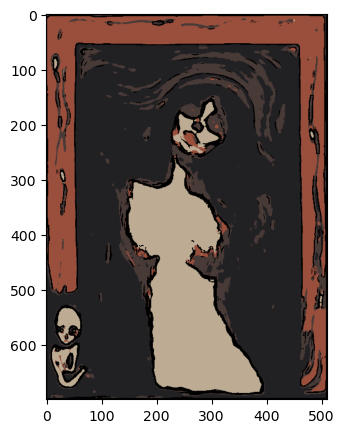

In [17]:
img_q = cent[c].reshape(img_f.shape)
edges = cv2.UMat(np.array(edges, dtype=np.uint8))

global cartoon

cartoon = img_q.copy()
edges = cv2.resize(edges, (cartoon.shape[1], cartoon.shape[0]))

cartoon[edges.get() == 0] = 0

plt.figure(figsize=(10, 5))
plt.imshow(cartoon)
plt.show()

#### Osservazioni:

Munch era noto per il suo uso del colore per esprimere emozioni intense: la quantizzazione dei colori ha influito ancora di più sull'intensità emotiva dell'opera, rendendo più accentuate le emozioni dall'accezione negativa grazie all'enfatizzazione del colore molto scuro dello sfondo a contrasto con la pelle candida della Madonna. Inoltre la sovrapposizione della maschera degli edge che "cerchia" gli occhi dei due personaggi (a indicare il distacco tra l'ombra della cavità oculare e il resto del viso) contribuisce ad aumentare questa sensazione di inquietudine.

Colore del pixel alla posizione (600, 300): [189 171 147]


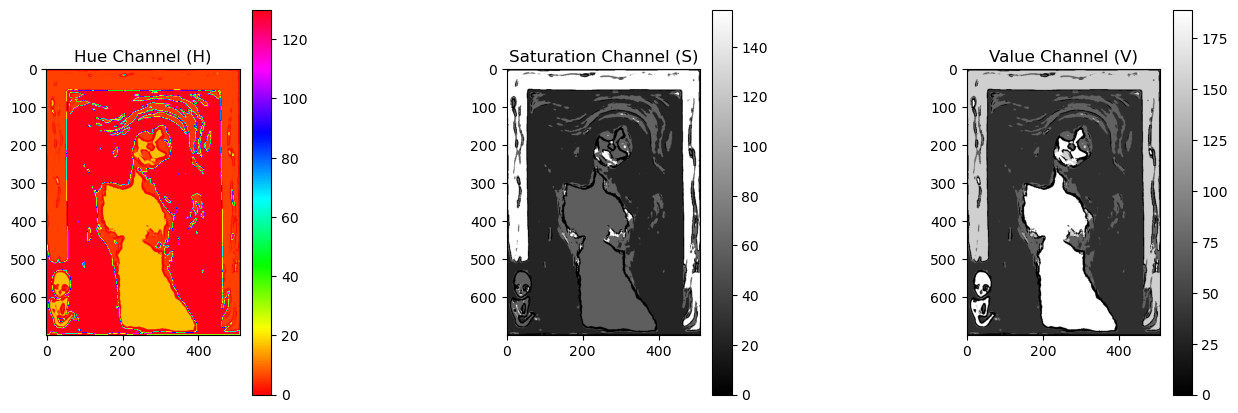

Hue value in the hue channel at position (600, 300): 17


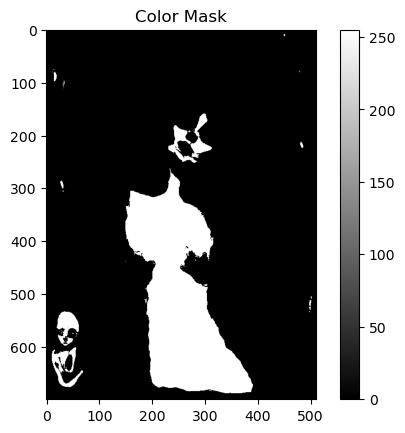

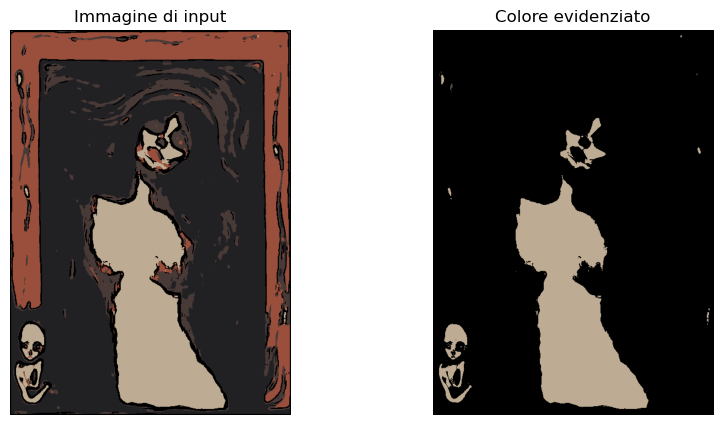

In [18]:
# Scegli il pixel da esaminare (ad esempio, il pixel nella riga 600 e colonna 300)
pixel_row = 600
pixel_col = 300

pixel_color = cartoon[pixel_row, pixel_col]
print(f"Colore del pixel alla posizione ({pixel_row}, {pixel_col}): {pixel_color}")

highlighted_image = highlight_color(cartoon, pixel_color, pixel_row, pixel_col)

plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.imshow(cartoon)
plt.title('Immagine di input')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(cv2.cvtColor(highlighted_image, cv2.COLOR_BGR2RGB))
plt.title('Colore evidenziato')
plt.axis('off')

plt.show()

In [19]:
def pop_art_effect_rgb(img, pixel_row, pixel_col, red_shift=0, green_shift=0, blue_shift=0):
    target_color = img[pixel_row, pixel_col]
    mask = np.all(img == target_color, axis=-1)
    img[mask] = np.clip(img[mask] + [red_shift, green_shift, blue_shift], 0, 255)
    return img

def update_pop_art_rgb(red_shift, green_shift, blue_shift, row, col):
    global current_image
    current_image = pop_art_effect_rgb(current_image, row, col, red_shift, green_shift, blue_shift)
    current_image = current_image.astype(np.uint8)
    plt.figure(figsize=(10, 5))
    return plt.imshow(current_image)

def save_image(b):
    global current_image
    current_image = current_image.astype(np.uint8)
    plt.imsave('saved_image.png', current_image)

    # Reset slider values to default
    red_slider.value = 0
    green_slider.value = 0
    blue_slider.value = 0
    row_slider.value = cartoon.shape[0]//2
    col_slider.value = cartoon.shape[1]//2

# Initialize the current image with the original image
current_image = cartoon.copy()

red_slider = widgets.IntSlider(min=-255, max=255, step=1, value=0, description='Red Shift:')
green_slider = widgets.IntSlider(min=-255, max=255, step=1, value=0, description='Green Shift:')
blue_slider = widgets.IntSlider(min=-255, max=255, step=1, value=0, description='Blue Shift:')
row_slider = widgets.IntSlider(min=0, max=cartoon.shape[0]-1, step=1, value=cartoon.shape[0]//2, description='y:')
col_slider = widgets.IntSlider(min=0, max=cartoon.shape[1]-1, step=1, value=cartoon.shape[1]//2, description='x:')
save_button = widgets.Button(description='Save Image')
save_button.on_click(save_image)

interactive_pop_art_rgb = interact(update_pop_art_rgb, red_shift=red_slider, green_shift=green_slider, blue_shift=blue_slider, row=row_slider, col=col_slider, continuous_update=False)

display(save_button)

interactive(children=(IntSlider(value=0, description='Red Shift:', max=255, min=-255), IntSlider(value=0, desc…

Button(description='Save Image', style=ButtonStyle())

### Caso di test 3 ("Fanciullo con canestro di frutta" di Caravaggio)

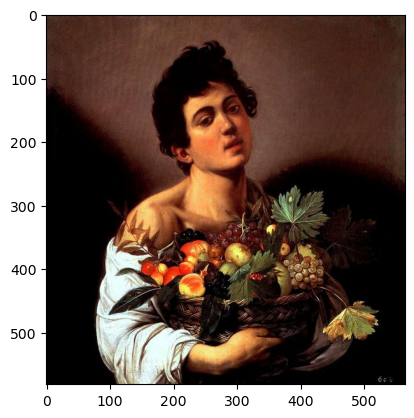

<Figure size 1000x500 with 0 Axes>

In [26]:
img = cv2.imread('images/fanciulloConFrutta.jpg')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) #converto l'immagine dal formato BGR di OpenCV al formato RGB
plt.imshow(img)
plt.figure(figsize=(10, 5))
plt.show()

In [27]:
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
gray = cv2.medianBlur(gray, 9)
gray = img_as_float(gray)
img_f = cv2.bilateralFilter(img, 9, 250, 250)

threshold_slider = IntSlider(min=1, max=100, step=1, value=10)

interact(plot_image, threshold=threshold_slider)

interactive(children=(IntSlider(value=10, description='threshold', min=1), Output()), _dom_classes=('widget-in…

<function __main__.plot_image(threshold)>

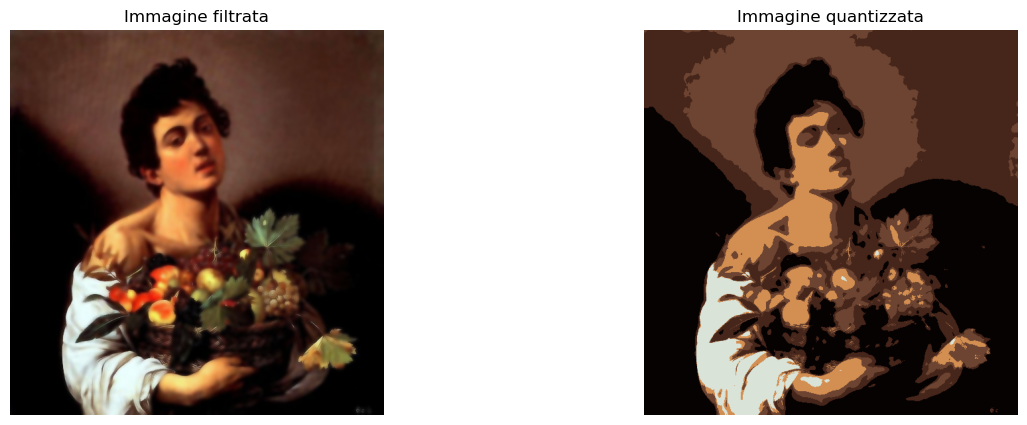

In [28]:
cent, c, dist = k_means(img_f, 5)

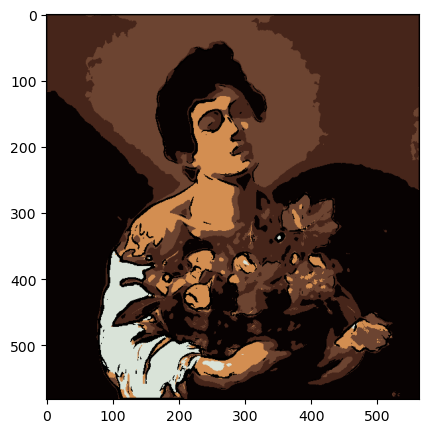

In [29]:
img_q = cent[c].reshape(img_f.shape)
edges = cv2.UMat(np.array(edges, dtype=np.uint8))

global cartoon

cartoon = img_q.copy()
edges = cv2.resize(edges, (cartoon.shape[1], cartoon.shape[0]))

cartoon[edges.get() == 0] = 0

plt.figure(figsize=(10, 5))
plt.imshow(cartoon)
plt.show()

#### Osservazioni:

Come in ogni opera di Caravaggio, l'elemento principale di questa immagine è il gioco della luce sulla figura: la luce spezza l'immagine in due metà, una sui toni molto chiari e una sui toni molto scuri, così come enfatizzato dall'operazione di quantizzazione eseguita che ha reso molto più nette le transizioni tra le zone più scure e più chiare. Possiamo notare in particolare come la quantizzazione abbia inglobato la parte sinistra del ragazzo rimasta in penombra nel dipinto originale con lo sfondo scuro, confermando così che il protagonista dell'opera non è veramente il soggetto, quanto più la luce.

Colore del pixel alla posizione (100, 100): [108  68  49]


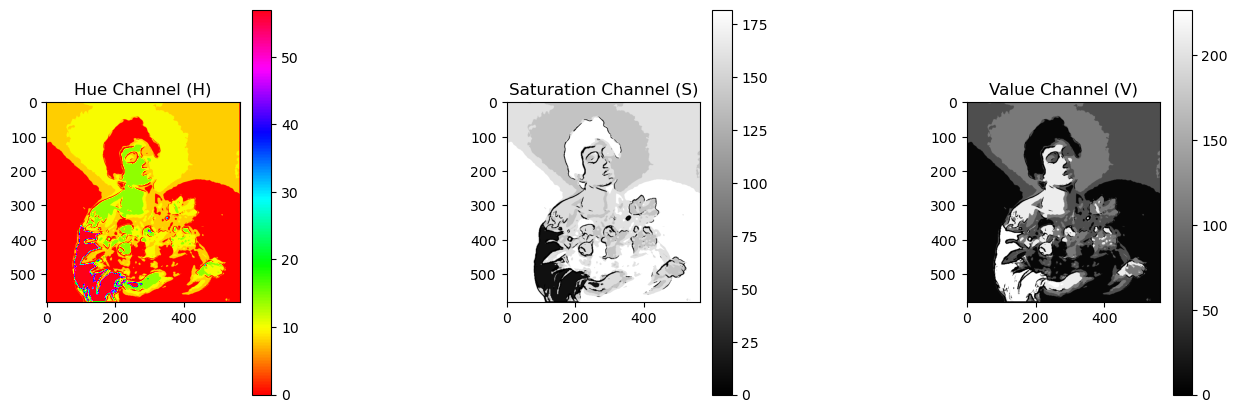

Hue value in the hue channel at position (100, 100): 10


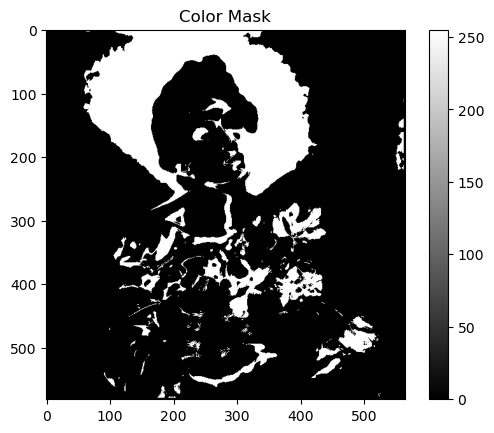

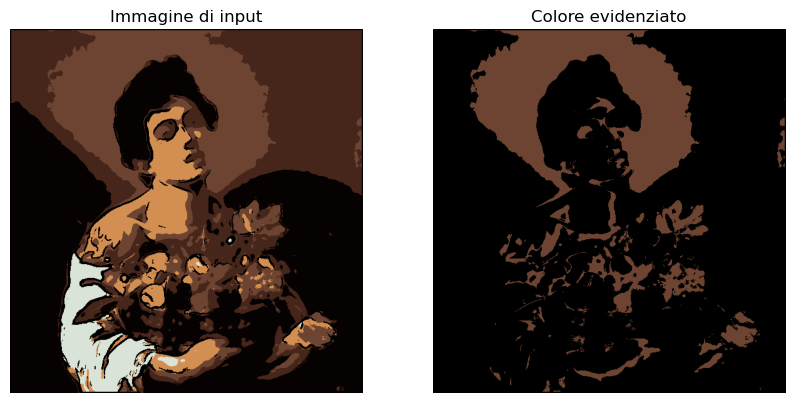

In [30]:
# Scegli il pixel da esaminare (ad esempio, il pixel nella riga 100 e colonna 100)
pixel_row = 100
pixel_col = 100

# Stampa il colore reale del pixel nella posizione specificata
pixel_color = cartoon[pixel_row, pixel_col]
print(f"Colore del pixel alla posizione ({pixel_row}, {pixel_col}): {pixel_color}")

# Applica la funzione per evidenziare il colore desiderato
highlighted_image = highlight_color(cartoon, pixel_color, pixel_row, pixel_col)

plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.imshow(cartoon)
plt.title('Immagine di input')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(cv2.cvtColor(highlighted_image, cv2.COLOR_BGR2RGB))
plt.title('Colore evidenziato')
plt.axis('off')

plt.show()

In [31]:
def pop_art_effect_rgb(img, pixel_row, pixel_col, red_shift=0, green_shift=0, blue_shift=0):
    target_color = img[pixel_row, pixel_col]
    mask = np.all(img == target_color, axis=-1)
    img[mask] = np.clip(img[mask] + [red_shift, green_shift, blue_shift], 0, 255)
    return img

def update_pop_art_rgb(red_shift, green_shift, blue_shift, row, col):
    global current_image
    current_image = pop_art_effect_rgb(current_image, row, col, red_shift, green_shift, blue_shift)
    current_image = current_image.astype(np.uint8)
    plt.figure(figsize=(10, 5))
    return plt.imshow(current_image)

def save_image(b):
    global current_image
    current_image = current_image.astype(np.uint8)
    plt.imsave('saved_image.png', current_image)

    # Reset slider values to default
    red_slider.value = 0
    green_slider.value = 0
    blue_slider.value = 0
    row_slider.value = cartoon.shape[0]//2
    col_slider.value = cartoon.shape[1]//2

# Initialize the current image with the original image
current_image = cartoon.copy()

red_slider = widgets.IntSlider(min=-255, max=255, step=1, value=0, description='Red Shift:')
green_slider = widgets.IntSlider(min=-255, max=255, step=1, value=0, description='Green Shift:')
blue_slider = widgets.IntSlider(min=-255, max=255, step=1, value=0, description='Blue Shift:')
row_slider = widgets.IntSlider(min=0, max=cartoon.shape[0]-1, step=1, value=cartoon.shape[0]//2, description='y:')
col_slider = widgets.IntSlider(min=0, max=cartoon.shape[1]-1, step=1, value=cartoon.shape[1]//2, description='x:')
save_button = widgets.Button(description='Save Image')
save_button.on_click(save_image)

interactive_pop_art_rgb = interact(update_pop_art_rgb, red_shift=red_slider, green_shift=green_slider, blue_shift=blue_slider, row=row_slider, col=col_slider, continuous_update=False)

display(save_button)

interactive(children=(IntSlider(value=0, description='Red Shift:', max=255, min=-255), IntSlider(value=0, desc…

Button(description='Save Image', style=ButtonStyle())

### Conclusioni:

In conclusione, da questo progetto si evince come la quantizzazione sia un'operazione potenzialmente utile per l'analisi di opere artistiche, poiché evidenzia quelli che erano gli scopi degli autori di questi dipinti, eliminando ogni possibile elemento di disturbo dall'immagine così da permetterci di fare un "focus" sui dettagli importanti e le caratteristiche principali.

Abbiamo visto anche una funzione per rendere in forma pop art questi dipinti, permettendo all'utente di scegliere le tinte con cui modificare l'immagine (magari scegliendo accostamenti di colore più azzeccati dei miei).